In [1]:
# === Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import random
import shutil

# === Path Setup ===
# Paths to the dataset inside Kaggle
base_path = '../'
image_folder = os.path.join(
    base_path, 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input')
labels_path = os.path.join(base_path, 'ISIC_2019_Training_GroundTruth.csv')

# Output directories
processed_dir = os.path.join(base_path, 'working', 'processed_images')
augmented_dir = os.path.join(base_path, 'working', 'augmented_images')
melanoma_dir = os.path.join(processed_dir, 'melanoma')
non_melanoma_dir = os.path.join(processed_dir, 'non_melanoma')

os.makedirs(processed_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)
os.makedirs(melanoma_dir, exist_ok=True)
os.makedirs(non_melanoma_dir, exist_ok=True)

# === Check Images ===
# List only .jpg image files (ignore folders)
image_files = [f for f in os.listdir(image_folder) if f.endswith(
    '.jpg') and os.path.isfile(os.path.join(image_folder, f))]

print("Total .jpg files found:", len(image_files))
print("Sample image names:", image_files[:5])

# === Load Labels CSV ===
df = pd.read_csv(labels_path)
print("\nTraining labels preview:")
print(df.head())

# === Melanoma vs. Non-Melanoma ===
melanoma_count = df[df["MEL"] == 1].shape[0]
non_melanoma_count = df[df["MEL"] == 0].shape[0]

print(f"\nMelanoma images: {melanoma_count}")
print(f"Non-Melanoma images: {non_melanoma_count}")

print("\nMEL column class distribution (%):")
print(df["MEL"].value_counts(normalize=True) * 100)

# Create simplified labels (focusing on melanoma classification only)
df_simplified = df[['image', 'MEL']]
print("\nSimplified labels (first 5 rows):")
print(df_simplified.head())

Total .jpg files found: 25331
Sample image names: ['ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000002.jpg', 'ISIC_0000003.jpg', 'ISIC_0000004.jpg']

Training labels preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Melanoma images: 4522
Non-Melanoma images: 20809

MEL column class distribution (%):
MEL
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64

Simplified labels (first 5 rows):
          image  MEL
0  ISIC_0000000  0.0
1  ISIC_0000001  0.0
2  ISIC_0000002  1.0
3  ISIC_0000003  0.0
4  ISIC_0000004  1.0


## Our Pipeline for Processing Images

In [22]:
import cv2
import numpy
import os
import time
import random

output_folder = "../working/processed_images"
os.makedirs(output_folder, exist_ok=True)


def process_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Vertical Kernel
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 11))  # Vertical kernel
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3,3), cv2.BORDER_DEFAULT)
    _, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    # Horizontal Kernel
    grayScale2 = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (11,7))  # Horizontal kernel
    blackhat2 = cv2.morphologyEx(grayScale2, cv2.MORPH_BLACKHAT, kernel2)
    bhg2 = cv2.GaussianBlur(blackhat2, (3,3), cv2.BORDER_DEFAULT)
    _, mask2 = cv2.threshold(bhg2, 10, 255, cv2.THRESH_BINARY)
    dst2 = cv2.inpaint(dst, mask2, 6, cv2.INPAINT_TELEA)
    grayScale3 = cv2.cvtColor(dst2, cv2.COLOR_RGB2GRAY)
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))  # Square kernel
    blackhat3 = cv2.morphologyEx(grayScale3, cv2.MORPH_BLACKHAT, kernel3)
    bhg3 = cv2.GaussianBlur(blackhat3, (3,3), cv2.BORDER_DEFAULT)
    _, mask3 = cv2.threshold(bhg3, 10, 255, cv2.THRESH_BINARY)
    dst3 = cv2.inpaint(dst2, mask3, 6, cv2.INPAINT_TELEA)

    # Median Blur
    md = cv2.medianBlur(dst3, 5)
    return dst3, md


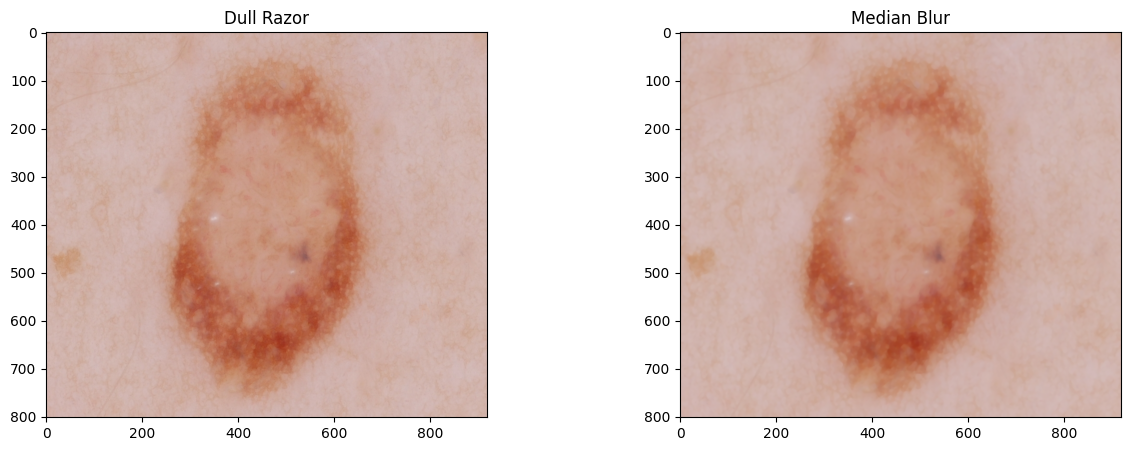

In [23]:
import random

import matplotlib.pyplot as plt

# Select a random image file
random_image = random.choice(image_files)
image_path = os.path.join(image_folder, random_image)

# Process the image
dull_razor, median_blur = process_image(image_path)

# Visualize the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(dull_razor, cv2.COLOR_BGR2RGB))
plt.title('Dull Razor')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))
plt.title('Median Blur')

plt.show()

In [25]:
for (count, image_file) in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)

    dull_razor, median_blur = process_image(image_path)

    base_filename = os.path.splitext(image_file)[0]
    os.path.join(output_folder, f"{base_filename}_{count}").replace("\\", "/")
    cv2.imwrite(os.path.join(output_folder, f"{base_filename}.jpg"), median_blur)


In [26]:
def create_file_lists():
    """Create separate lists for melanoma and non-melanoma images"""
    print("Creating file lists for melanoma and non-melanoma images...")

    melanoma_files = []
    non_melanoma_files = []

    for index, row in df_simplified.iterrows():
        image_name = row['image']
        is_melanoma = row['MEL'] == 1.0

        base_filename = image_name
        processed_img_path = os.path.join(
            output_folder, f"{base_filename}.jpg").replace("\\", "/")

        if os.path.exists(processed_img_path):
            if is_melanoma:
                target_path = os.path.join(
                    melanoma_dir, f"{base_filename}.jpg").replace("\\", "/")
                melanoma_files.append(processed_img_path)
                shutil.copy(processed_img_path, target_path)
            else:
                target_path = os.path.join(
                    non_melanoma_dir, f"{base_filename}.jpg").replace("\\", "/")
                non_melanoma_files.append(processed_img_path)
                shutil.copy(processed_img_path, target_path)

        processed_img_path = os.path.join(
            output_folder, f"{base_filename}_downsampled_hist_eq.jpg").replace("\\", "/")

    melanoma_file_path = os.path.join(
        base_path, 'working', 'melanoma_files.txt')
    non_melanoma_file_path = os.path.join(
        base_path, 'working', 'non_melanoma_files.txt')

    with open(melanoma_file_path, 'w') as f:
        f.write('\n'.join(melanoma_files))

    with open(non_melanoma_file_path, 'w') as f:
        f.write('\n'.join(non_melanoma_files))

    print(
        f"Created file lists: {len(melanoma_files)} melanoma files and {len(non_melanoma_files)} non-melanoma files")
    return melanoma_files, non_melanoma_files


# Execute the function to create file lists
melanoma_files, non_melanoma_files = create_file_lists()

Creating file lists for melanoma and non-melanoma images...
Created file lists: 4522 melanoma files and 20809 non-melanoma files
